# Querying tables

> Objectives:
> * Compare queries of tabular data for **in-memory** containers
> * Compare sizes and times for those

In [1]:
from ipython_memwatcher import MemWatcher
mw = MemWatcher()
mw.start_watching_memory()

In [1] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 41.574 MiB


In [2]:
import os
dset = 'movielens-1m'
fdata = os.path.join(dset, 'ratings.dat.gz')
fitem = os.path.join(dset, 'movies.dat')

In [2] used 2.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 43.574 MiB


In [3]:
import pandas as pd
# pass in column names for each CSV
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(fdata, sep=';', names=r_cols, compression='gzip')

m_cols = ['movie_id', 'title', 'genres']
movies = pd.read_csv(fitem, sep=';', names=m_cols,
                     dtype={'title': object, 'genres': object})

In [3] used 70.023 MiB RAM in 0.444s, peaked 7.016 MiB above current, total RAM usage 113.598 MiB


In [4]:
movies.dtypes

movie_id     int64
title       object
genres      object
dtype: object

In [4] used 0.449 MiB RAM in 0.007s, peaked 0.000 MiB above current, total RAM usage 114.047 MiB


In [5]:
lens = pd.merge(movies, ratings)

In [5] used 54.668 MiB RAM in 0.070s, peaked 23.266 MiB above current, total RAM usage 168.715 MiB


In [6]:
size_pandas = mw.measurements.memory_delta
size_pandas

54.66796875

In [6] used 0.027 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 168.742 MiB


In [7]:
# pandas also comes with its own tool for getting memory usage
print(lens.memory_usage())

Index             8001672
movie_id          8001672
title             8001672
genres            8001672
user_id           8001672
rating            8001672
unix_timestamp    8001672
dtype: int64
In [7] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 168.742 MiB


### Exercise

1) Why do you think that the size is the same for every column in the dataframe?

*Hint:* pandas stores the string columns in NumPy containers with 'object' dtype.

2) Provided how the `lens` DataFrame looks like:

In [8]:
lens.head()

,movie_id,title,genres,user_id,rating,unix_timestamp
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474


In [8] used 0.000 MiB RAM in 0.007s, peaked 0.000 MiB above current, total RAM usage 168.742 MiB


In [9]:
lens.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 6 columns):
movie_id          1000209 non-null int64
title             1000209 non-null object
genres            1000209 non-null object
user_id           1000209 non-null int64
rating            1000209 non-null int64
unix_timestamp    1000209 non-null int64
dtypes: int64(4), object(2)
memory usage: 53.4+ MB
In [9] used 24.570 MiB RAM in 0.117s, peaked 0.000 MiB above current, total RAM usage 193.312 MiB


Do you think this is all the memory that the DataFrame tables?

### Solution

In [10]:
# Use deep=True for including the size of the object types
print(lens.memory_usage(deep=True))

Index              8001672
movie_id           8001672
title             80347206
genres            71665151
user_id            8001672
rating             8001672
unix_timestamp     8001672
dtype: int64
In [10] used 0.004 MiB RAM in 0.126s, peaked 0.000 MiB above current, total RAM usage 193.316 MiB


In [11]:
# For a more realistic memory usage, we are going to use deep=True
size_pandas2 = lens.memory_usage(deep=True).sum() / 2**20.
size_pandas2

183.12522602081299

In [11] used -1.953 MiB RAM in 0.125s, peaked 0.000 MiB above current, total RAM usage 191.363 MiB


## Querying a pandas DataFrame

In [12]:
# Let's do a typical query in pandas and see how fast it can be
t = %timeit -o lens.query("(title == 'Tom and Huck (1995)') & (rating == 5)")['user_id']
result = lens.query("(title == 'Tom and Huck (1995)') & (rating == 5)")['user_id']
result

10 loops, best of 3: 33.1 ms per loop


5121      75
5164    3842
5187    6031
Name: user_id, dtype: int64

In [12] used 0.500 MiB RAM in 1.401s, peaked 0.000 MiB above current, total RAM usage 191.863 MiB


In [13]:
# Store it for future reference
qtime_pandas = t.best

In [13] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 191.863 MiB


## Use a compressed in-memory container via `bcolz`

In [14]:
import bcolz
bcolz.print_versions()
bcolz.defaults.cparams['cname'] = 'lz4'
bcolz.defaults.cparams['clevel'] = 9
bcolz.defaults.cparams['shuffle'] = bcolz.BITSHUFFLE  # try with NOSHUFFLE and BITSHUFFLE as well
bcolz.set_nthreads(1)

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
bcolz version:     1.0.0
NumPy version:     1.11.1
Blosc version:     1.8.1 ($Date:: 2016-04-08 #$)
Blosc compressors: ['blosclz', 'lz4', 'lz4hc', 'snappy', 'zlib']
Numexpr version:   2.6.1
Python version:    3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Platform:          linux-x86_64
Byte-ordering:     little
Detected cores:    8
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


8

In [14] used 5.789 MiB RAM in 0.057s, peaked 0.000 MiB above current, total RAM usage 197.652 MiB


In [15]:
zlens = bcolz.ctable.fromdataframe(lens)

In [15] used 0.664 MiB RAM in 0.276s, peaked 78.207 MiB above current, total RAM usage 198.316 MiB


In [16]:
zlens

ctable((1000209,), [('movie_id', '<i8'), ('title', 'S82'), ('genres', 'S47'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8')])
  nbytes: 153.57 MB; cbytes: 7.30 MB; ratio: 21.04
  cparams := cparams(clevel=9, shuffle=2, cname='lz4')
[(1, b'Toy Story (1995)', b"Animation|Children's|Comedy", 1, 5, 978824268)
 (1, b'Toy Story (1995)', b"Animation|Children's|Comedy", 6, 4, 978237008)
 (1, b'Toy Story (1995)', b"Animation|Children's|Comedy", 8, 4, 978233496)
 ...,
 (3952, b'Contender, The (2000)', b'Drama|Thriller', 5837, 4, 1011902656)
 (3952, b'Contender, The (2000)', b'Drama|Thriller', 5927, 1, 979852537)
 (3952, b'Contender, The (2000)', b'Drama|Thriller', 5998, 4, 1001781044)]

In [16] used 0.000 MiB RAM in 0.005s, peaked 0.000 MiB above current, total RAM usage 198.316 MiB


We can see that the space taken by a bcolz container is around 20x smaller (!) than a pandas one.

In [17]:
size_bcolz = mw.measurements.memory_delta
size_bcolz

0.0

In [17] used 0.078 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 198.395 MiB


We see that the reported memory consumption is *really* low, so let's take the internal estimation for comparison purposes.

In [18]:
zlens

ctable((1000209,), [('movie_id', '<i8'), ('title', 'S82'), ('genres', 'S47'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8')])
  nbytes: 153.57 MB; cbytes: 7.30 MB; ratio: 21.04
  cparams := cparams(clevel=9, shuffle=2, cname='lz4')
[(1, b'Toy Story (1995)', b"Animation|Children's|Comedy", 1, 5, 978824268)
 (1, b'Toy Story (1995)', b"Animation|Children's|Comedy", 6, 4, 978237008)
 (1, b'Toy Story (1995)', b"Animation|Children's|Comedy", 8, 4, 978233496)
 ...,
 (3952, b'Contender, The (2000)', b'Drama|Thriller', 5837, 4, 1011902656)
 (3952, b'Contender, The (2000)', b'Drama|Thriller', 5927, 1, 979852537)
 (3952, b'Contender, The (2000)', b'Drama|Thriller', 5998, 4, 1001781044)]

In [18] used 0.000 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 198.395 MiB


In [19]:
size_bcolz2 = zlens.cbytes / 2**20.

In [19] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 198.395 MiB


In [20]:
size_pandas2 / size_bcolz2

25.092422540077553

In [20] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 198.395 MiB


## Querying a bcolz ctable

In [21]:
# Workaround to use bytes instead of Unicode (not supported yet in numexpr queries)
title = zlens['title'][:].astype('S82')
zlens.delcol('title')
zlens.addcol(title, 'title')

In [21] used 78.223 MiB RAM in 0.067s, peaked 0.324 MiB above current, total RAM usage 276.617 MiB


In [22]:
# Workaround to use bytes instead of Unicode (not supported yet in numexpr queries)
genre = zlens['genres'][:].astype('S47')
zlens.delcol('genres')
zlens.addcol(genre, 'genres')

In [22] used 44.836 MiB RAM in 0.042s, peaked 0.164 MiB above current, total RAM usage 321.453 MiB


In [23]:
# Querying a bcolz dataset
resultz = [(r.nrow__, r.user_id) for r in zlens.where("(title == b'Tom and Huck (1995)') & (rating == 5)", outcols=['nrow__', 'user_id'])]
t = %timeit -o [(r.nrow__, r.user_id) for r in zlens.where("(title == b'Tom and Huck (1995)') & (rating == 5)", outcols=['nrow__', 'user_id'])]

10 loops, best of 3: 31.9 ms per loop
In [23] used 0.191 MiB RAM in 1.346s, peaked 0.000 MiB above current, total RAM usage 321.645 MiB


In [24]:
qtime_bcolz = t.best

In [24] used 0.000 MiB RAM in 0.000s, peaked 0.000 MiB above current, total RAM usage 321.645 MiB


In [25]:
qtime_pandas / qtime_bcolz

1.0386095038873533

In [25] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 321.645 MiB


We see that by using a compressed bcolz container, it provides similar query times than pandas.

In [26]:
# Sanity check (always check for your results!)
print("results with pandas Dataframe:", result)
print("results with bcolz ctable:", resultz)

results with pandas Dataframe: 5121      75
5164    3842
5187    6031
Name: user_id, dtype: int64
results with bcolz ctable: [(5121, 75), (5164, 3842), (5187, 6031)]
In [26] used 0.074 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 321.719 MiB


## Use a *uncompressed* in-memory container via `bcolz`

So, what happens when we use an uncompressed container in bcolz?  We do expect better speed?  If so, how much?  Let's measure:

In [27]:
bcolz.defaults.cparams['clevel'] = 0

In [27] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 321.719 MiB


In [28]:
uzlens = bcolz.ctable.fromdataframe(lens)
uzlens

ctable((1000209,), [('movie_id', '<i8'), ('title', 'S82'), ('genres', 'S47'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8')])
  nbytes: 153.57 MB; cbytes: 154.54 MB; ratio: 0.99
  cparams := cparams(clevel=0, shuffle=2, cname='lz4')
[(1, b'Toy Story (1995)', b"Animation|Children's|Comedy", 1, 5, 978824268)
 (1, b'Toy Story (1995)', b"Animation|Children's|Comedy", 6, 4, 978237008)
 (1, b'Toy Story (1995)', b"Animation|Children's|Comedy", 8, 4, 978233496)
 ...,
 (3952, b'Contender, The (2000)', b'Drama|Thriller', 5837, 4, 1011902656)
 (3952, b'Contender, The (2000)', b'Drama|Thriller', 5927, 1, 979852537)
 (3952, b'Contender, The (2000)', b'Drama|Thriller', 5998, 4, 1001781044)]

In [28] used 262.293 MiB RAM in 0.197s, peaked 0.000 MiB above current, total RAM usage 584.012 MiB


In [29]:
size_ubcolz = mw.measurements.memory_delta
size_ubcolz

262.29296875

In [29] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 584.012 MiB


In [30]:
size_ubcolz2 = uzlens.cbytes / 2**20.
size_ubcolz2

154.54058456420898

In [30] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 584.012 MiB


In [31]:
size_pandas2 / size_ubcolz2

1.1849652732789266

In [31] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 584.012 MiB


We can see that the space taken by an uncompressed bcolz container is very close to a pandas one (but keep an eye on the reported memory usage by memory_watcher).

In [32]:
# Workaround to use bytes instead of Unicode (not supported yet in numexpr queries)
title = zlens['title'][:].astype('S82')
uzlens.delcol('title')
uzlens.addcol(title, 'title')

In [32] used 0.336 MiB RAM in 0.045s, peaked 78.602 MiB above current, total RAM usage 584.348 MiB


In [33]:
# Querying a bcolz dataset
resultz = [(r.nrow__, r.user_id) for r in uzlens.where("(title == b'Tom and Huck (1995)') & (rating == 5)", outcols=['nrow__', 'user_id'])]
t = %timeit -o [(r.nrow__, r.user_id) for r in uzlens.where("(title == b'Tom and Huck (1995)') & (rating == 5)", outcols=['nrow__', 'user_id'])]

100 loops, best of 3: 12.9 ms per loop
In [33] used 1.043 MiB RAM in 5.367s, peaked 0.000 MiB above current, total RAM usage 585.391 MiB


In [34]:
qtime_ubcolz = t.best

In [34] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 585.391 MiB


In [35]:
qtime_pandas / qtime_ubcolz

2.5621266523483928

In [35] used 0.008 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 585.398 MiB


## Using structured NumPy arrays

In [36]:
nalens = zlens[:]

In [36] used 153.492 MiB RAM in 0.133s, peaked 0.000 MiB above current, total RAM usage 738.891 MiB


In [37]:
size_numpy = mw.measurements.memory_delta
size_numpy

153.4921875

In [37] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 738.891 MiB


In [38]:
nalens

array([(1, 1, 5, 978824268, b'Toy Story (1995)', b"Animation|Children's|Comedy"),
       (1, 6, 4, 978237008, b'Toy Story (1995)', b"Animation|Children's|Comedy"),
       (1, 8, 4, 978233496, b'Toy Story (1995)', b"Animation|Children's|Comedy"),
       ...,
       (3952, 5837, 4, 1011902656, b'Contender, The (2000)', b'Drama|Thriller'),
       (3952, 5927, 1, 979852537, b'Contender, The (2000)', b'Drama|Thriller'),
       (3952, 5998, 4, 1001781044, b'Contender, The (2000)', b'Drama|Thriller')], 
      dtype=[('movie_id', '<i8'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8'), ('title', 'S82'), ('genres', 'S47')])

In [38] used 0.016 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 738.906 MiB


In [39]:
size_numpy2 = round((nalens.size * nalens.dtype.itemsize) / 2**20., 3)
size_numpy2

153.574

In [39] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 738.906 MiB


In [40]:
# But, again, this does not account for 'O'bject dtypes, which are stored in its own storage area
# So, let's take this into account
import sys
size_numpy3 = size_numpy2 + round(sum(sum(sys.getsizeof(o) for o in nalens[col]) for col in ('title', 'genres')) // 2**20., 3)
size_numpy3

301.574

In [40] used 0.000 MiB RAM in 0.638s, peaked 0.000 MiB above current, total RAM usage 738.906 MiB


In [41]:
resultna = nalens[(nalens['title'] == 'Tom and Huck (1995)') & (nalens['rating'] == 5)]
t = %timeit -o nalens[(nalens['title'] == 'Tom and Huck (1995)') & (nalens['rating'] == 5)]
resultna

100 loops, best of 3: 8.78 ms per loop


array([], 
      dtype=[('movie_id', '<i8'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8'), ('title', 'S82'), ('genres', 'S47')])

In [41] used 0.156 MiB RAM in 3.635s, peaked 0.000 MiB above current, total RAM usage 739.062 MiB


Again, NumPy works the fastest for in-memory data containers, while memory consumption is close to pandas (a hair less actually).

In [42]:
qtime_numpy = t.best

In [42] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 739.062 MiB


## Performance comparsion

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [43] used 3.531 MiB RAM in 0.071s, peaked 0.000 MiB above current, total RAM usage 742.594 MiB


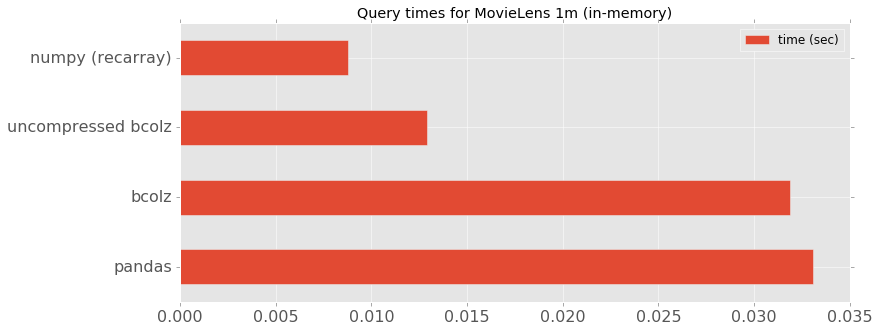

In [44] used 5.645 MiB RAM in 0.185s, peaked 0.000 MiB above current, total RAM usage 748.238 MiB


In [44]:
# Query times
labels = ["pandas", "bcolz", "uncompressed bcolz", "numpy (recarray)"]
df = pd.DataFrame({'time (sec)': [qtime_pandas, qtime_bcolz, qtime_ubcolz, qtime_numpy]}, index=labels)
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Query times for MovieLens 1m (in-memory)")

## Size comparison

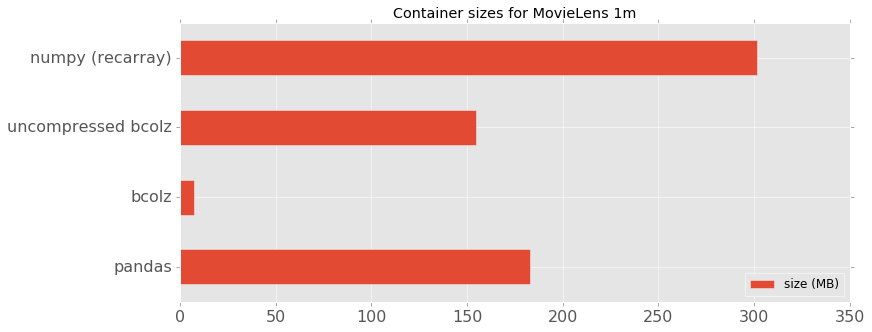

In [45] used 0.578 MiB RAM in 0.178s, peaked 0.000 MiB above current, total RAM usage 748.816 MiB


In [45]:
# Container sizes
df = pd.DataFrame({'size (MB)': [size_pandas2, size_bcolz2, size_ubcolz2, size_numpy3]}, index=labels)
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Container sizes for MovieLens 1m")

## Rules of thumb for querying in-memory tabular datasets

* Choose pure NumPy recarrays if you need the fastest speed
* Choose bcolz ctables if you need to store lots of data in limited memory and not want to loose too much speed
* Choose pandas if what you need is rich functionality on top of your containers (at the penalty of some speed)